COMP9414 24T2 Assignment2 

Xuan Wang

zID:z5442066

# Part1 Algorithm

The taxi environment comes from: https://gymnasium.farama.org/environments/toy_text/taxi/


In this environment, a taxi moves within a 5x5 grid where the yellow square represents the taxi's position, the blue letter is the passenger pickup point, and the pink letter is the drop-off point. The aim is to transport the passenger to the designated destination in the fewest steps possible.


Q-learning is an off-policy reinforcement learning method that emphasizes maximizing all possible actions. This method allows updating the target policy independently of the current behavior policy, leading to a stronger exploration capability. The Q-table is updated using the maximum Q-value of the next state, with the update rule given by:
Q(s, a) ← Q(s, a) + α (r + γ max Q(s', a') - Q(s, a))


SARSA, on the other hand, is an on-policy reinforcement learning method where the learning policy is the same as the behavior policy. This approach is more conservative compared to Q-learning. The Q-value update in SARSA uses the actual action taken in the next state, following the rule:
Q(s, a) ← Q(s, a) + α (r + γ Q(s', a') - Q(s, a))


During training, we use an advanced ε-greedy strategy. Epsilon starts with a high initial value and gradually decays to a minimum value as training progresses. This approach allows the agent to explore better in the early stages of training and exploit the accumulated knowledge more effectively as training progresses, thus accelerating convergence. Given our initial epsilon of 1, decay rate of 0.995, and minimum epsilon of 0.05, epsilon is updated in each learning cycle according to the formula:
ε ← max(min_epsilon, ε * ε_decay).
It is calculated that epsilon will decay to the minimum exploration rate by the 598th episode.

The learning rate (alpha) determines the step size for updating the Q-value or other parameters. If the learning rate is too high, the agent might overly rely on the latest information, ignoring previously accumulated experience. Conversely, a very low learning rate results in overly conservative updates, slowing the learning process.

The discount factor (gamma) measures the importance of future rewards. When gamma is close to 0, the agent prioritizes immediate rewards and tends to ignore future rewards. When gamma is close to 1, the agent considers long-term rewards, aiming for a strategy that maximizes cumulative future rewards.

## 1.1 Q-learning algorithm and results

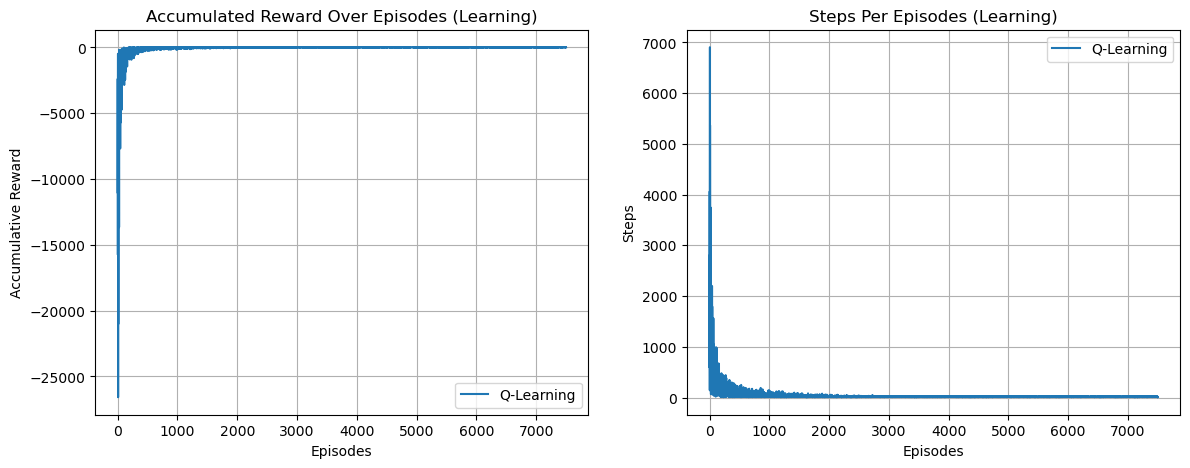

In [96]:
from collections import defaultdict
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import warnings


# Define Q-learning algorithm
def q_learning(env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon):
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []  # Record the accumulative rewards of each round
    steps = []  # Record the number of steps in each round

    for episode in range(episodes):
        # example of state: (393, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})
        state = env.reset()
        state = state[0]  # Use the first element of the state

        # Record total rewards and total steps
        total_rewards = 0
        total_steps = 0

        # If the taxi does not take the passenger to the destination, the round will not end 
        # (end condition: reaching the destination or the round is truncated)
        done = False
        while not done:
            if random.uniform(0, 1) < epsilon:
                # Randomly select an action with probability ε (exploration)
                action = env.action_space.sample()
            else:
                # Select the action with the highest current Q value with a probability of 1-ε (exploitation)
                action = np.argmax(q_table[state])

            # Execute the selected action and obtain the next state, reward, round end flag and other information
            next_state, reward, done, truncated, info = env.step(action)
            next_state = next_state[0] if isinstance(next_state, tuple) else next_state  # Use the first element of the state


            # Update Q value: choose the action with the largest Q value in the next state
            best_next_action = np.argmax(q_table[next_state])  
            q_table[state][action] += alpha * ((reward + gamma * q_table[next_state][best_next_action]) - q_table[state][action])

            state = next_state  # Update state to next state
            total_rewards += reward  # Accumulated rewards
            total_steps += 1  # Increased number of steps

        # Update the exploration rate ε, which is reduced by the decay factor, but not lower than the minimum exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)  

        # Record the cumulative rewards and steps of this round
        rewards.append(total_rewards) 
        steps.append(total_steps)

    # The function returns the trained Q table, the cumulative reward and the number of steps for each round
    return q_table, rewards, steps

# Initialize the environment
env = gym.make("Taxi-v3", render_mode="ansi")

# Set Hyperparameters
alpha = 0.05  # Learning rete
gamma = 0.95  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995  # Exploration rate decay
min_epsilon = 0.05  # Minimum exploration rate
episodes = 7500  # Number of learning cycles

# Train and save the results
q_table_q_learning, rewards_q_learning, steps_q_learning = q_learning(env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon)

# Convert a defaultdict to a standard dictionary
q_table_q_learning = dict(q_table_q_learning)

# Save Q Table
np.save('q_table_q_learning.npy', q_table_q_learning)

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Plot the cumulative reward and number of steps during learning
plt.figure(figsize=(14, 5))

# Plot the cumulative reward graph
plt.subplot(1, 2, 1)
plt.plot(rewards_q_learning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Accumulative Reward')
plt.title('Accumulated Reward Over Episodes (Learning)')
plt.legend()
plt.grid(True)

# Plotting the Step Count
plt.subplot(1, 2, 2)
plt.plot(steps_q_learning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('Steps Per Episodes (Learning)')
plt.legend()
plt.grid(True)

plt.show()

## 1.2 SARSA algorithm and results

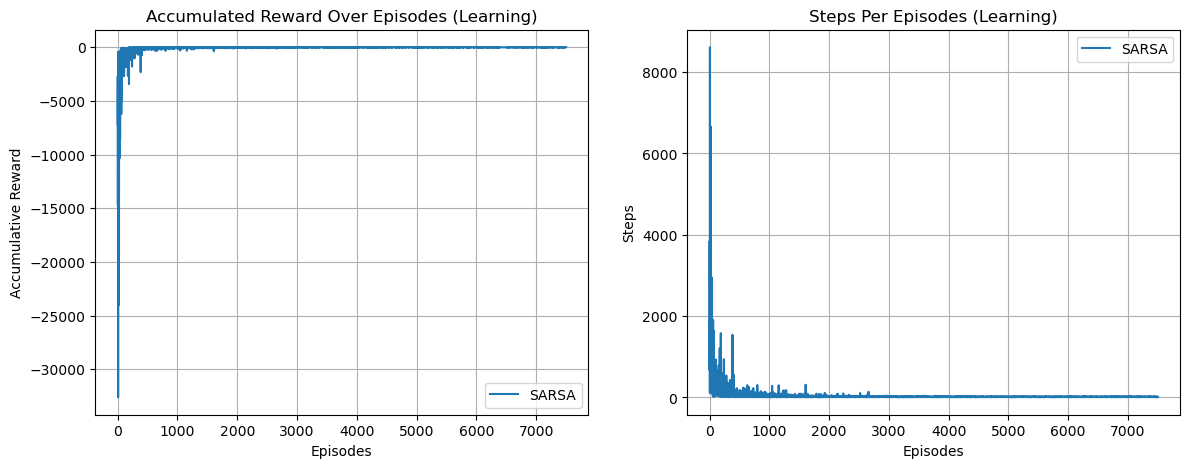

In [98]:
# Define SARSA algorithm
def sarsa(env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon):
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []  # Record the accumulative rewards of each round
    steps = []  # Record the number of steps in each round

    for episode in range(episodes):
        # example of state: (393, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})
        state = env.reset()
        state = state[0]  # Use the first element of the state

        # Record total rewards and total steps
        total_rewards = 0
        total_steps = 0

        # Select initial action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Randomly select an action with probability ε (exploration)
        else:
            # Select the action with the highest current Q value with a probability of 1-ε (exploitation)
            action = np.argmax(q_table[state])


        # If the taxi does not take the passenger to the destination, the round will not end 
        # (end condition: reaching the destination or the round is truncated)
        done = False
        while not done:
            # Execute the selected action and obtain the next state, reward, round end flag and other information
            next_state, reward, done, truncated, info = env.step(action)
            next_state = next_state[0] if isinstance(next_state, tuple) else next_state  # Use the first element of the state

            # Randomly select an action with probability ε (exploration)
            if random.uniform(0, 1) < epsilon:
                # Randomly select an action with probability ε (exploration)
                next_action = env.action_space.sample()  
            else:
                # Select the action with the highest current Q value with a probability of 1-ε (exploitation)
                next_action = np.argmax(q_table[next_state])

            # Update Q value: uses the Q value of the action actually taken in the next state
            q_table[state][action] += alpha * ((reward + gamma * q_table[next_state][next_action]) - q_table[state][action])
            

            state = next_state  # Update state to next state
            action = next_action  # Update action to next action
            total_rewards += reward  # Accumulated rewards
            total_steps += 1  # Increased number of steps

        # Update the exploration rate ε, which is reduced by the decay factor, but not lower than the minimum exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Record the cumulative rewards and steps of this round
        rewards.append(total_rewards)
        steps.append(total_steps)

    # The function returns the trained Q table, the accumulative reward and the number of steps for each round
    return q_table, rewards, steps


# Initialize the environment
env = gym.make("Taxi-v3", render_mode="ansi")

# Set Hyperparameters
alpha = 0.05  # Learning rete
gamma = 0.95  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995  # Exploration rate decay
min_epsilon = 0.05  # Minimum exploration rate
episodes = 7500  # Number of learning cycles

# Train and save the results
q_table_sarsa, rewards_sarsa, steps_sarsa = sarsa(env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon)

# Convert a defaultdict to a standard dictionary
q_table_sarsa = dict(q_table_sarsa)

# Save Q Table
np.save('q_table_sarsa.npy', q_table_sarsa)

# Plot the accumulative reward and number of steps during learning
plt.figure(figsize=(14, 5))

# Plot the cumulative reward graph
plt.subplot(1, 2, 1)
plt.plot(rewards_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Accumulative Reward')
plt.title('Accumulated Reward Over Episodes (Learning)')
plt.legend()
plt.grid(True)

# Plot the Step Count
plt.subplot(1, 2, 2)
plt.plot(steps_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('Steps Per Episodes (Learning)')
plt.legend()
plt.grid(True)

plt.show()


## 1.3 Visualization of the trained agent

In [100]:
# Visualize the trained agent
def visualize_agent(env, q_table, max_steps=100):
    # Set the initial state
    state = env.reset()
    state = state[0] if isinstance(state, tuple) else state

    # Set total reward
    total_reward = 0

    # Within the maximum number of steps, the taxi performs actions
    for step in range(max_steps):
        action = np.argmax(q_table[state])  # Use the greedy strategy
        next_state, reward, done, truncated, info = env.step(action)
        next_state = next_state[0] if isinstance(next_state, tuple) else next_state
        total_reward += reward
        state = next_state
        
        print(env.render())
        print(f"Step: {step + 1} \nState: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {total_reward}")
        if done:
            break
    print(f"Total Accumulated Reward: {total_reward}")

# Set up the environment
env = gym.make("Taxi-v3", render_mode="ansi")

# Visualization using trained Q-learning agent
print("Visualizing Q-learning Agent:")
visualize_agent(env, q_table_q_learning)


Visualizing Q-learning Agent:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1 
State: 262, Action: 1, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 2 
State: 242, Action: 3, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3 
State: 222, Action: 3, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 4 
State: 122, Action: 1, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 5 
State: 102, Action: 3, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 6 
State: 2, Action: 1, Reward: 

In [101]:
# Visualization using trained SARSA agent
print("Visualizing SARSA Agent:")
visualize_agent(env, q_table_sarsa)

Visualizing SARSA Agent:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 1 
State: 322, Action: 3, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 2 
State: 222, Action: 1, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3 
State: 202, Action: 3, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 4 
State: 102, Action: 1, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 5 
State: 2, Action: 1, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 6 
State: 18, Action: 4, Reward: -1, 

# Part2 Testing

In [111]:
from collections import defaultdict
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)


# Load Q table
def load_q_table(file_name):
    return np.load(file_name, allow_pickle=True).item()

# Run the agent and return the total reward and number of steps
# max_steps: If the agent fails to complete the task within this number of steps, the round will be forced to end
def run_agent(env, q_table, max_steps=100, render=False):
    state = env.reset()

    state = state[0]  # Use the first element of the state
    total_reward = 0
    step = 0
    
    done = False
    while not done and step < max_steps:
        action = np.argmax(q_table[state])  # Apply the greedy strategy
        next_state, reward, done, truncated, info = env.step(action)
        next_state = next_state[0] if isinstance(next_state, tuple) else next_state  # Use the first element of the state

        # If you need to visualize all tests, please uncomment the following code
        
        # # Render environment, using ansi mode
        # rendered_env = env.render()
        # print(rendered_env)
        
        # # Print current step information
        # print(f"Step: {step + 1} \nState: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {total_reward}")

        state = next_state
        total_reward += reward
        step += 1

    return total_reward, step


# Test the agent and return the average reward and average number of steps
# num_tests: Number of test rounds to perform
def test_agent(q_table, num_tests=200, max_steps=100):
    # Record the total reward and number of steps for each test
    total_rewards = []
    total_steps = []

    # Run multiple tests, running the agent in each test, recording the reward and number of steps for each test
    for i in range(num_tests):
        print(f"Running test {i + 1}/{num_tests}...")
        env = gym.make("Taxi-v3", render_mode="ansi")
        total_reward, steps = run_agent(env, q_table, max_steps, render=False)
        total_rewards.append(total_reward)
        total_steps.append(steps)

    # Calculate average reward and average number of steps
    average_reward = np.mean(total_rewards)
    average_steps = np.mean(total_steps)

    return average_reward, average_steps


# Load and test the Q table of the Q-learning algorithm
q_table_q_learning = load_q_table('q_table_q_learning.npy')
print("Testing Q-learning Agent:")
average_reward_q_learning, average_steps_q_learning = test_agent(q_table_q_learning)
print(f"Q-learning - Average Reward: {average_reward_q_learning}, Average Steps: {average_steps_q_learning}")

# Load and test the Q table of the SARSA algorithm
q_table_sarsa = load_q_table('q_table_sarsa.npy')
print("\nTesting SARSA Agent:")
average_reward_sarsa, average_steps_sarsa = test_agent(q_table_sarsa)
print(f"SARSA - Average Reward: {average_reward_sarsa}, Average Steps: {average_steps_sarsa}")


Testing Q-learning Agent:
Running test 1/200...
Running test 2/200...
Running test 3/200...
Running test 4/200...
Running test 5/200...
Running test 6/200...
Running test 7/200...
Running test 8/200...
Running test 9/200...
Running test 10/200...
Running test 11/200...
Running test 12/200...
Running test 13/200...
Running test 14/200...
Running test 15/200...
Running test 16/200...
Running test 17/200...
Running test 18/200...
Running test 19/200...
Running test 20/200...
Running test 21/200...
Running test 22/200...
Running test 23/200...
Running test 24/200...
Running test 25/200...
Running test 26/200...
Running test 27/200...
Running test 28/200...
Running test 29/200...
Running test 30/200...
Running test 31/200...
Running test 32/200...
Running test 33/200...
Running test 34/200...
Running test 35/200...
Running test 36/200...
Running test 37/200...
Running test 38/200...
Running test 39/200...
Running test 40/200...
Running test 41/200...
Running test 42/200...
Running test 43/2